In [61]:
class eucliDist_clssifier():
    def __init__(self,track):
        self.target = track
        
    def distance(self, v1, v2):
        return np.sqrt(np.sum((v1 - v2) ** 2))   
    
    def predict(self,Persons):
        matched = []
        for curPer in Persons:
            dist = self.distance(self.target,curPer)
            print(dist)
            if dist > 1:
                matched.append(1)
            else:
                matched.append(0)
#                 print('matched')
        
        return matched
        

In [63]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from scipy import misc
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import argparse
import facenet
import detect_face
import os
from os.path import join as pjoin
import sys
import time
import copy
import math
import pickle
from sklearn.svm import SVC
from sklearn.externals import joblib

print('Creating networks and loading parameters')
with tf.Graph().as_default():
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.6)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=False))
    with sess.as_default():
        pnet, rnet, onet = detect_face.create_mtcnn(sess, '../facenet/src/align/')

        minsize = 20  # minimum size of face
        threshold = [0.6, 0.7, 0.7]  # three steps's threshold
        factor = 0.709  # scale factor
        margin = 44
        frame_interval = 3
        batch_size = 1000
        image_size = 182
        input_image_size = 160

        HumanNames = ['Bee','Deemarc','UNKNOWN','UNKNOWN','UNKNOWN']    #train human name

        print('Loading feature extraction model')
        modeldir = './modelSaved/20170511-185253/20170511-185253.pb'
        facenet.load_model(modeldir)

        images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
        embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
        phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
        embedding_size = embeddings.get_shape()[1]

        classifier_filename = './class/my_classifier.pkl'
        classifier_filename_exp = os.path.expanduser(classifier_filename)
        with open(classifier_filename_exp, 'rb') as infile:
            (model, class_names) = pickle.load(infile)
            print('load classifier file-> %s' % classifier_filename_exp)

Creating networks and loading parameters
Loading feature extraction model
Model filename: ./modelSaved/20170511-185253/20170511-185253.pb
load classifier file-> ./class/my_classifier.pkl


This image is: <class 'numpy.ndarray'> with dimensions: (200, 200, 3)


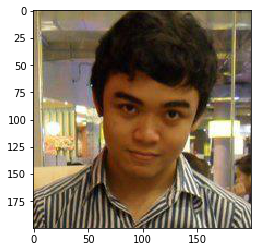

In [71]:
%matplotlib inline
frame = mpimg.imread('input/deemarc/429401_10150679861246866_648104187_n.jpg')
#printing out some stats and plotting
print('This image is:', type(frame), 'with dimensions:', frame.shape)
plt.imshow(frame)

Detected_FaceNum: 2
plotting...
1.31580256217
[1]
result:  1
Unable to align
Deemarc
Unable to align
Unable to align
Unable to align
1.3461615408
[1]
result:  1
Unable to align
Deemarc
Unable to align
Unable to align
Unable to align


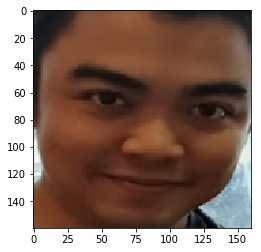

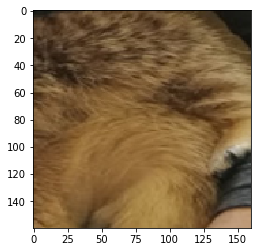

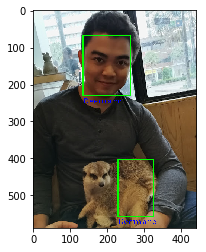

In [70]:
    if frame.ndim == 2:
        frame = facenet.to_rgb(frame)
        
    frame = frame[:, :, 0:3]
    bounding_boxes, _ = detect_face.detect_face(frame, minsize, pnet, rnet, onet, threshold, factor)
    nrof_faces = bounding_boxes.shape[0]
    print('Detected_FaceNum: %d' % nrof_faces)

    if nrof_faces > 0:
        print('plotting...')
        det = bounding_boxes[:, 0:4]
        img_size = np.asarray(frame.shape)[0:2]

        cropped = []
        scaled = []
        scaled_reshape = []
        bb = np.zeros((nrof_faces,4), dtype=np.int32)

        for i in range(nrof_faces):
            emb_array = np.zeros((1, embedding_size))
            bb[i][0] = det[i][0]
            bb[i][1] = det[i][1]
            bb[i][2] = det[i][2]
            bb[i][3] = det[i][3]

            # inner exception
            if bb[i][0] <= 0 or bb[i][1] <= 0 or bb[i][2] >= len(frame[0]) or bb[i][3] >= len(frame):
                print('face is inner of range!')
                continue

#             cropped.append(frame[bb[i][1]:bb[i][3], bb[i][0]:bb[i][2], :])
            cropped = frame[bb[i][1]:bb[i][3], bb[i][0]:bb[i][2], :]
            
#             cropped[0] = facenet.flip(cropped[0], False)
#             scaled.append(misc.imresize(cropped[0], (image_size, image_size), interp='bilinear'))
            scaled = misc.imresize(cropped, (image_size, image_size), interp='bilinear')
            scaled = cv2.resize(scaled, (input_image_size,input_image_size),
                                interpolation=cv2.INTER_CUBIC)
#             scaled = facenet.prewhiten(scaled)
            scaled_reshape = scaled.reshape(-1,input_image_size,input_image_size,3)
            feed_dict = {images_placeholder: scaled_reshape, phase_train_placeholder: False}
            emb_array[0, :] = sess.run(embeddings, feed_dict=feed_dict)
            plt.figure()
            plt.imshow(scaled)
            predictions = model.predict(emb_array)
            
#             best_class_indices = np.argmax(predictions, axis=1)
#             best_class_probabilities = predictions[np.arange(len(best_class_indices)), best_class_indices]
            print(predictions)
#             print(best_class_indices)
#             print(best_class_probabilities)
            cv2.rectangle(frame, (bb[i][0], bb[i][1]), (bb[i][2], bb[i][3]), (0, 255, 0), 2)    #boxing face
            
            #plot result idx under box
            text_x = bb[i][0]
            text_y = bb[i][3] + 20
            print('result: ', best_class_indices[0])
            for H_i in HumanNames:
                if HumanNames[best_class_indices[0]] == H_i:
                    result_names = HumanNames[best_class_indices[0]]
                    print(result_names)
                    cv2.putText(frame, result_names, (text_x, text_y), cv2.FONT_HERSHEY_COMPLEX_SMALL,
                                1, (0, 0, 255), thickness=1, lineType=2)
                else:
                    print('Unable to align')

            # c+=1

plt.figure()
plt.imshow(frame)

In [66]:
print('fin')

fin


In [ ]:
a = predictions[0]
print(a)
best_class_indices = np.argmax(a)
print(best_class_indices)
# best_class_indices = np.argmax(predictions[0], axis=1)